# Titanic Data Set

Learning goals:
1. Get confident with pandas data frames
2. Use visualisation to get a feeling for signal detection
3. Build some naive predictors
4. Understand the principle behind the random forrest predictor
5. Develop something new that at least does passably well

Constraints:
1. AI can be used to assist in the creation of code snippets, but only if every line of code is completely clear.

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
import re

DATA_DIR = Path("Data") / "titanic"  # adjust if needed
train_path = DATA_DIR /"train.csv"
test_path = DATA_DIR /"test.csv"
print("Looking for:", test_path.resolve()) #Short sanity check to see where the training files should go to.
print("Exists:", test_path.exists())    #And If they exist

train_data = pd.read_csv(train_path) #Loading the data into pandas data frames.
test_data = pd.read_csv(test_path)


print(train_data.shape)
train_data.head() #First Overview Of What we have


Looking for: /Users/lassegrimmelt/PycharmProjects/PythonProject/Data/titanic/test.csv
Exists: True
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To get a feeling of the data, I would like to do some basic stastics on the numerical values.


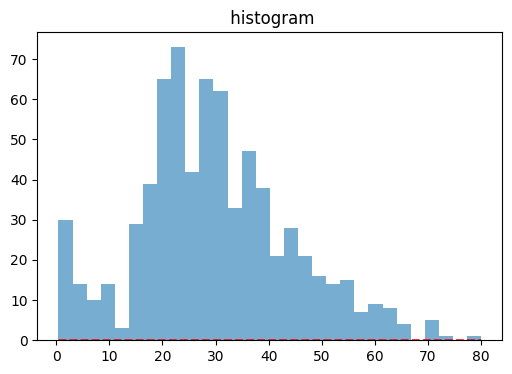

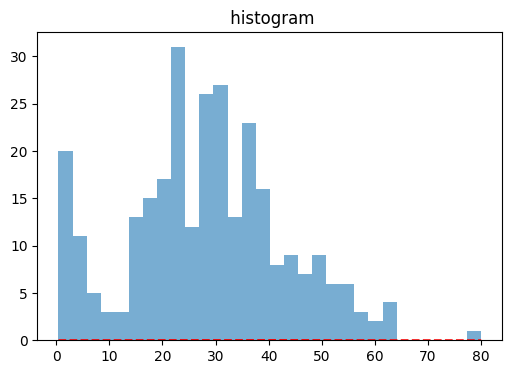

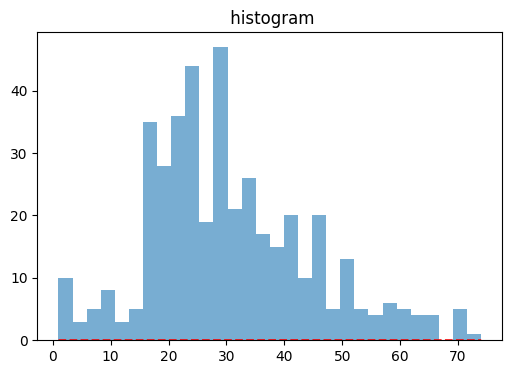

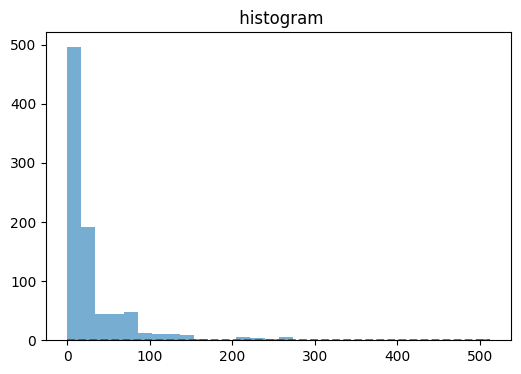

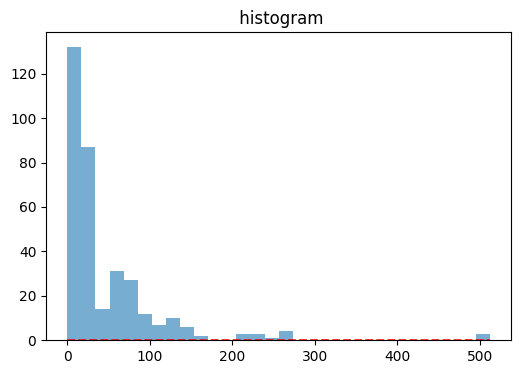

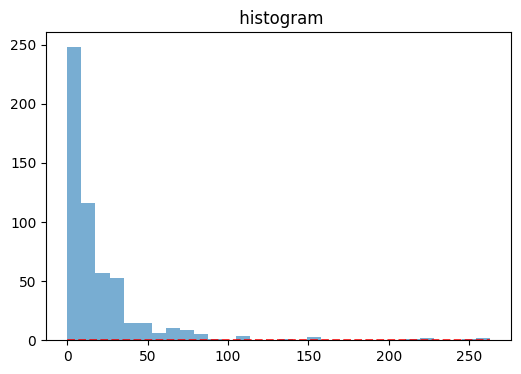

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

def plot_histogram(df):
    x = df.dropna()
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=False, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f" histogram")
    plt.show()


plot_histogram(train_data["Age"])
plot_histogram(train_data.loc[train_data["Survived"] == 1, "Age"])
plot_histogram(train_data.loc[train_data["Survived"] == 0, "Age"])

plot_histogram(train_data["Fare"])
plot_histogram(train_data.loc[train_data["Survived"] == 1, "Fare"])
plot_histogram(train_data.loc[train_data["Survived"] == 0, "Fare"])

asd I would like to better understand the effect of age on the survival rate. For that reason, I want to plot the difference of the the survive histogram and the died histogram. However, the data is to granular, so I first want to put a kernel density estimator over it to smoothen.

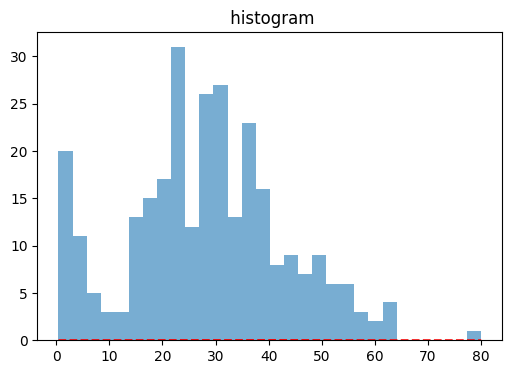

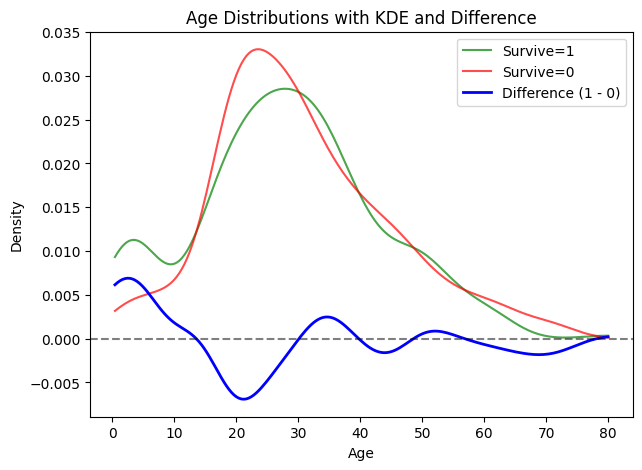

In [42]:
def plot_smooth_age_difference(df, age_col="Age", survive_col="Survived" ):
    all_ages = df[age_col].dropna()
    base_kde = gaussian_kde(all_ages)
    bw = base_kde.factor
    df = df[[age_col, survive_col]].dropna()


    # Split into survivors and non-survivors
    ages_survive1 = df.loc[df[survive_col] == 1, age_col]
    ages_survive0 = df.loc[df[survive_col] == 0, age_col]

    plot_histogram(ages_survive1)
    kde1 = gaussian_kde(ages_survive1, bw_method=bw)
    kde0 = gaussian_kde(ages_survive0, bw_method=bw)

    # Evaluation grid
    xs = np.linspace(df[age_col].min(), df[age_col].max(), 200)
    # Densities
    d1 = kde1(xs)
    d0 = kde0(xs)

    # Difference
    diff = d1 - d0

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(xs, d1, label="Survive=1", color="green", alpha=0.7)
    plt.plot(xs, d0, label="Survive=0", color="red", alpha=0.7)
    plt.plot(xs, diff, label="Difference (1 - 0)", color="blue", linewidth=2)
    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Age Distributions with KDE and Difference")
    plt.show()

plot_smooth_age_difference(train_data)



REMARK: This is actually normalised for int=1, which is nice looking but  not the right normalisation for predictor models, this is changed in the next cell.

From this we see that as first approximation grouping age into 10 year chunk should be fine, so that gives us $8$ categories.
Let's look at Fare next, and let's take a logarithm of fare price.

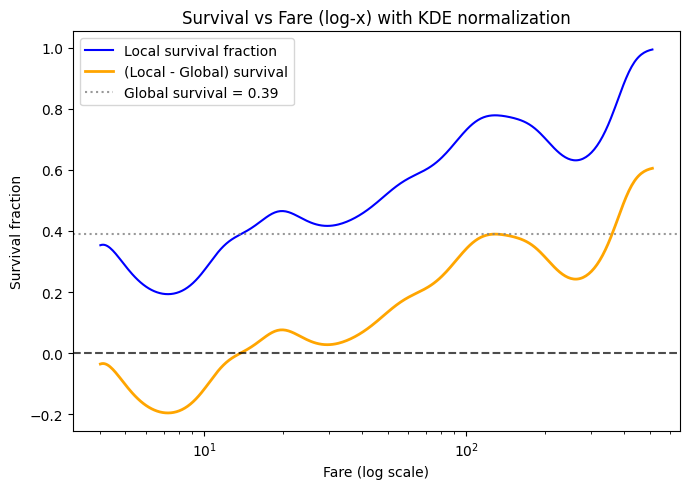

In [8]:
    """
    Plot KDEs of Survived=1 vs Survived=0 on log(Fare),
    and show the *normalized* difference: local survival rate - overall survival rate.
    Includes dashed 0-line.
    """
    sub = df[[fare_col, survive_col]].dropna()
    sub = sub[sub[fare_col] > 0]
    if sub.empty:
        print("No positive fares to plot.")
        return

    fares = sub[fare_col].values
    z_all = np.log(fares)
    if len(z_all) < 2 or np.isclose(np.std(z_all), 0.0):
        print("Not enough variability in log(Fare) for KDE.")
        return

    # group splits
    z1 = np.log(sub.loc[sub[survive_col] == 1, fare_col].values)
    z0 = np.log(sub.loc[sub[survive_col] == 0, fare_col].values)
    n1, n0 = len(z1), len(z0)
    if n1 < 2 or n0 < 2:
        print("Not enough data in one of the groups for KDE.")
        return
    p = n1 / (n1 + n0)  # global survival rate

    # common bandwidth for fair comparison
    bw = gaussian_kde(z_all).factor
    kde1 = gaussian_kde(z1, bw_method=bw)
    kde0 = gaussian_kde(z0, bw_method=bw)

    xmin, xmax = fares.min(), fares.max()
    xs = np.logspace(np.log10(xmin), np.log10(xmax), 400)

    # densities in original x scale
    d1 = kde1(np.log(xs)) / xs
    d0 = kde0(np.log(xs)) / xs

    # normalized "local survival minus global"
    local_survival = (p * d1) / (p * d1 + (1 - p) * d0)
    diff_norm = local_survival - p

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(xs, local_survival, label="Local survival fraction", color="blue")
    plt.plot(xs, diff_norm, label="(Local - Global) survival", color="orange", linewidth=2)
    plt.xscale("log")
    plt.axhline(p, color="gray", linestyle=":", alpha=0.8, label=f"Global survival = {p:.2f}")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # dashed 0-line
    plt.xlabel("Fare (log scale)")
    plt.ylabel("Survival fraction")
    plt.title("Survival vs Fare (log-x) with KDE normalization")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_smooth_fare_log_difference(train_data)

How to build a predictor? My naive guess would be the following:
1. Choose 4-5 highly predictive cateogries
2. Split them into buckets
3. For each bucket calculate the relative survivale rate
4. Use a kernel blurring to fill gaps and smoothen out
5. Use as predictor

Gaps:
1. Buckets should be replaced by smooth versions again, maybe that would make smoothening afterwards unneccessary?
2. We assume that 'closeness in buckets' implies 'closeness in result', but that may not be the case at all. Better would be a graph based method in which adjacency is learned.